# Align multiple EOForestSTAC collections

This notebook demonstrates how to:
1. Load multiple EOForestSTAC collections
2. Subset them to a common region of interest
3. Align them to a common spatial grid
4. Perform direct, pixel-wise analysis

In [11]:
from eoforeststac.providers.zarr import ZarrProvider
from eoforeststac.providers.subset import subset
from eoforeststac.providers.align import DatasetAligner

import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
provider = ZarrProvider(
    catalog_url="https://s3.gfz-potsdam.de/dog.atlaseo-glm.eo-gridded-data/collections/public/catalog.json",
    endpoint_url="https://s3.gfz-potsdam.de",
    anon=True,
)

In [13]:
ds_biomass = provider.open_dataset(
    collection_id="CCI_BIOMASS",
    version="6.0",
)

ds_efda = provider.open_dataset(
    collection_id="EFDA",
    version="2.1.1",
)

print(ds_biomass)
print(ds_efda)

<xarray.Dataset> Size: 13TB
Dimensions:                  (latitude: 202500, longitude: 405000, time: 10)
Coordinates:
  * latitude                 (latitude) float64 2MB 90.0 90.0 ... -90.0 -90.0
  * longitude                (longitude) float64 3MB -180.0 -180.0 ... 180.0
  * time                     (time) datetime64[ns] 80B 2007-01-01 ... 2022-01-01
    crs                      int64 8B ...
Data variables:
    aboveground_biomass      (latitude, longitude, time) float64 7TB dask.array<chunksize=(1000, 1000, 5), meta=np.ndarray>
    aboveground_biomass_std  (latitude, longitude, time) float64 7TB dask.array<chunksize=(1000, 1000, 5), meta=np.ndarray>
Attributes:
    _FillValue:          -9999
    contact:             Maurizio Santoro (GAMMA RS)
    created_by:          Santoro et al.
    creation_date:       2025-12-13 11:00
    crs:                 EPSG:4326
    description:         Global forest aboveground biomass maps for 2007–2022...
    institution:         European Space Agency

In [ ]:
roi_path = "/geojson/DE-Hai.geojson"
roi = gpd.read_file(roi_path)
geometry = roi.to_crs("EPSG:4326").geometry.union_all()

In [15]:
ds_biomass_sel = subset(
    ds_biomass,
    geometry=geometry,
    time=("2007-01-01", "2020-12-31"),
)

ds_efda_sel = subset(
    ds_efda,
    geometry=geometry,
    time=("2007-01-01", "2020-12-31"),
)

print(ds_biomass_sel)
print(ds_efda_sel)

<xarray.Dataset> Size: 513kB
Dimensions:                  (latitude: 50, longitude: 80, time: 8)
Coordinates:
  * latitude                 (latitude) float64 400B 51.1 51.1 ... 51.06 51.06
  * longitude                (longitude) float64 640B 10.42 10.42 ... 10.49
  * time                     (time) datetime64[ns] 64B 2007-01-01 ... 2020-01-01
    crs                      int64 8B ...
Data variables:
    aboveground_biomass      (latitude, longitude, time) float64 256kB dask.array<chunksize=(50, 80, 5), meta=np.ndarray>
    aboveground_biomass_std  (latitude, longitude, time) float64 256kB dask.array<chunksize=(50, 80, 5), meta=np.ndarray>
Attributes:
    _FillValue:          -9999
    contact:             Maurizio Santoro (GAMMA RS)
    created_by:          Santoro et al.
    creation_date:       2025-12-13 11:00
    crs:                 EPSG:4326
    description:         Global forest aboveground biomass maps for 2007–2022...
    institution:         European Space Agency (ESA) Clima

In [16]:
aligner = DatasetAligner(
    target="CCI_BIOMASS",
    resampling={
        "CCI_BIOMASS": "average",
        "EFDA": "nearest",
    },
)

aligned = aligner.align({
    "CCI_BIOMASS": ds_biomass_sel.sel(time='2020-01-01'),
    "EFDA": ds_efda_sel.sel(time='2020-01-01'),
})

print(aligned)

<xarray.Dataset> Size: 129kB
Dimensions:                  (longitude: 80, latitude: 50)
Coordinates:
  * longitude                (longitude) float64 640B 10.42 10.42 ... 10.49
  * latitude                 (latitude) float64 400B 51.1 51.1 ... 51.06 51.06
    time                     datetime64[ns] 8B 2020-01-01
    crs                      int64 8B 0
Data variables:
    aboveground_biomass      (latitude, longitude) float64 32kB 146.0 ... nan
    aboveground_biomass_std  (latitude, longitude) float64 32kB 58.0 ... nan
    efda_agent               (latitude, longitude) float64 32kB nan nan ... nan
    efda_disturbance         (latitude, longitude) float64 32kB nan nan ... nan
Attributes:
    _FillValue:          -9999
    contact:             Maurizio Santoro (GAMMA RS)
    created_by:          Santoro et al.
    creation_date:       2025-12-13 11:00
    description:         Global forest aboveground biomass maps for 2007–2022...
    institution:         European Space Agency (ESA) Cli

In [17]:
def reduce_for_plot(da):
    if "members" in da.dims:
        da = da.median("members")

    if "time" in da.dims:
        if da.sizes["time"] > 1:
            da = da.mean("time")
        else:
            da = da.isel(time=0)

    return da

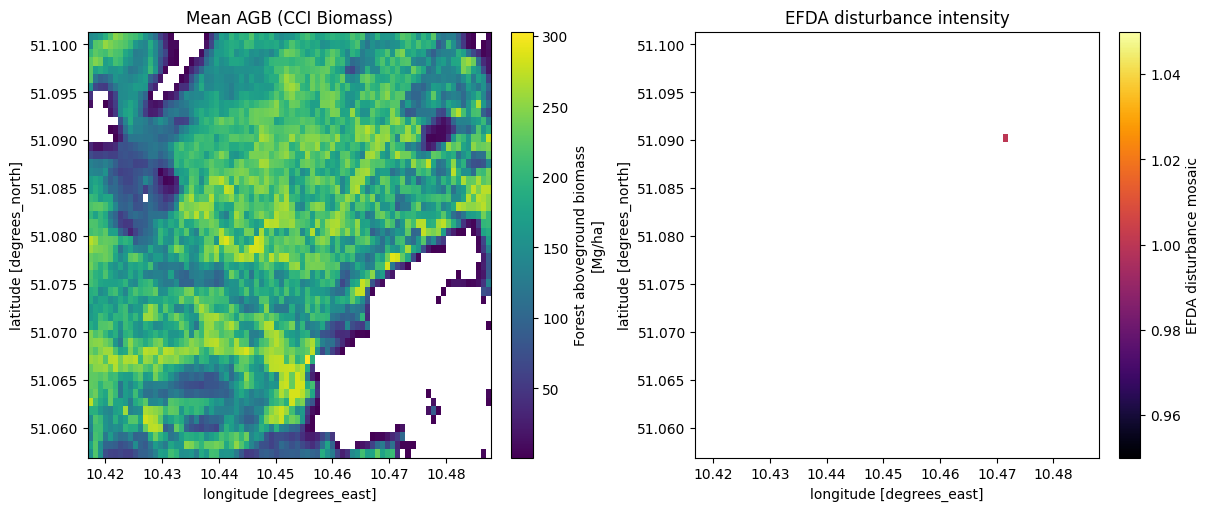

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

reduce_for_plot(aligned.aboveground_biomass).plot(
    ax=axes[0], cmap="viridis"
)
axes[0].set_title("Mean AGB (CCI Biomass)")

reduce_for_plot(aligned.efda_disturbance).plot(
    ax=axes[1], cmap="inferno"
)
axes[1].set_title("EFDA disturbance intensity")

plt.show()